# E-field calculation and the E-field-spin coupling effect

In [32]:
#importing crucial packages
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

In [33]:
#helpful function - don't worry about it

#just a function showing a progress bar in the console
import time, sys

def percentDone(x):
    """ 
    x is a float from 0 to 1 representing the progress of a given task 
    this function prints and updates the printout with the percentage of a given task done: 
    """
    n = int(x*20)
    percent = int(x*100)
    hashes = "#"*n+" "*(20-n)
    bar = "|"+hashes+"|"+str(percent)+"% done "
    print("\r"+bar,end='')

If the radius of the wire is $a$ and the distance between the wires is $d$, linear charge density is $\lambda$, then E-field due to both wires is given by
$$\boldsymbol{E}(x,y) = \frac{\lambda}{2 \pi \varepsilon_0} \left(\frac{d+x}{(x+d)^2+y^2)}+\frac{d-x}{(x-d)^2+y^2)}, \frac{y}{(x+d)^2+y^2)}+\frac{-y}{(x-d)^2+y^2)} \right)$$
Integrating from the edge of one wire to the edge of another wire gives the potential difference between the two wires:
$$V = \frac{\lambda}{\pi \varepsilon_0} \ln \left( \frac{2d+a}{a} \right)$$
Knowing voltage, we can write $\boldsymbol{E}$ as
$$\boldsymbol{E}(x,y) =  \frac{V}{2 \ln \left( \frac{2d+a}{a} \right)} \left(\frac{d+x}{(x+d)^2+y^2)}+\frac{d-x}{(x-d)^2+y^2)}, \frac{y}{(x+d)^2+y^2)}+\frac{-y}{(x-d)^2+y^2)} \right)$$

Because the calculation of the E-field values at random points takes time, I am calculating it only once.

In [34]:
def generateGrid(N,halfDistance,wire,tube):
    """
    generates a logically consistent grid to calculate the E-field values at
    """
    base = np.linspace(-tube,tube,N)
    x = np.tile(base,N)
    y = np.repeat(base,N)
    firstWire = np.sqrt((x-halfDistance)**2+y**2)
    secondWire = np.sqrt((x+halfDistance)**2+y**2)
    insTube = np.sqrt(x**2+y**2)
    wireLam = lambda z: (z>wire)
    tubeLam = lambda z: (z<tube)
    mask = wireLam(firstWire)*wireLam(secondWire)*tubeLam(insTube)
    
    finalX = x[mask,...]
    finalY = y[mask,...]
    
    return finalX, finalY

In [35]:
def getE(x,y,halfDistance,maxVoltage):
    """
    calculates the value of both components of E-field for a given point
    """
    d = halfDistance
    constant = maxVoltage/(2*np.log((2*d+wire)/wire))
    
    E_x1 = constant*(x+d)/((x+d)**2+y**2)
    E_x2 = constant*(d-x)/((x-d)**2+y**2)
    E_y1 = constant*y/((x+d)**2+y**2)
    E_y2 = -constant*y/((x-d)**2+y**2)
    
    E_x = E_x1+E_x2
    E_y = E_y1+E_y2
    
    return (E_x,E_y)

We assume a very simple model, where 

$$\Delta \boldsymbol{g} = a \boldsymbol{E}$$

where $a$ is some coupling strength. In other words, a change in $g_x$ is only due to $E_x$ etc. 
Because in the Hamiltonian the g-tensor multiplies the magnetic field, which in this picture is in the $x$ direction, we actually only ever need $E_x$. 

As stated in the variable definitions above, I don't know what $a$ is, so I don't bother adding in all the constants that should be there. That means I will use a constant $\gamma$, which contains the magnetic field. From the dot product between the magnetic field and the change in the tensor we get $\gamma E_x \cos(\theta)$, where $\theta$ is the angle between the $\boldsymbol{B_0}$ and $\boldsymbol{E}$. The additional phase factor is:

$$e^{i \gamma E_x \cos(\theta) t}$$

Where $t$ is time. Assuming the distribution of active molecules is isotropic, we need to integrate that over a surface of a sphere:

$$\int_0^{\pi} \sin (\theta) e^{i \gamma E_x \cos(\theta) t} d \theta = 2 \frac{\sin (\gamma E_x t)}{\gamma E_x t}$$

Then, we need to average over all the sample volume with this phase factor. 

An even simpler model is just to assume that $\Delta f = a |\boldsymbol{E}|$. This way we don't assume anything about the microstructure of the molecule, just the broken inversion symmetry. This does not explicitly allow us to shift the phase shift to reals and does not explain how it averages. But we know that it does somehow distribute itself. To answer this question properly, we *need the microstructure of the molecule*. For now, I am just going to assume a simple angular distribution like the one calculated above - this gives us the sinc function, we are just going to use the total $\boldsymbol{E}$ instead of only one of its components.

In [36]:
def totalPhaseFactor(EtValues,EScoupling,time):
    """
    calculates the averaged phase factor across all the E-field values for given EScoupling
    """
    N=len(EtValues)

    phase = EScoupling*time*EtValues
    factors = np.sin(phase)/phase

    
    total = np.average(factors)
    return total

In [37]:
def echoESweep(EtValues,EScoupling,k,tottime):
    """
    k is the number of steps taken. must be odd
    tottime is total time
    EScoupling is the coupling
    ExValues are values of E_x component of the electric field across the ensemble, precalculated
    """
    times = np.linspace(0,tottime/2,int((k+1)/2))
    alltimes = np.concatenate((times,times[-2::-1]))
    factors = np.zeros(k)+1
    for i in range(k):
        if alltimes[i]==0:
            factors[i]=1
        else:
            factors[i] = totalPhaseFactor(EtValues, EScoupling, alltimes[i])
        percentDone((i+1)/k)
    
    print("\n")
    return factors

Let's actually begin

# CHANGE VARIABLES HERE

In [38]:
#SPECIFY ALL THE IMPORTANT VARIABLES AND CONSTANTS

halfDistance = 0.85e-3 #half of the distance between the wires in metres
wire = 0.15e-3 #radius of the wire in metres
tube = 1e-3 #radius of the sample tube in metres

maxVoltage = 150 #in volts

EScoupling = 16 #since we don't know what it is for now it just enters as phase = EScoupling*Efield, without all the
                #Bohr magneton and magnetic field stuff. can be changed later

N = 10000 #grid dimension (approx pi/4 N^2 points total)
m = 20000 #number of bins for histogram
k = 59 #number of steps in the E-field experiment
tottime = 1.5e-6 #total length of the pulse in seconds

In [39]:
#generate points for the graph (the graph takes a lot of time to render so we just use 1000 x 1000 grid)
x,y = generateGrid(1000,halfDistance,wire,tube)
E_x, E_y = getE(x,y,halfDistance,maxVoltage)
E_t = np.sqrt(E_x**2+E_y**2)

<IPython.core.display.Javascript object>


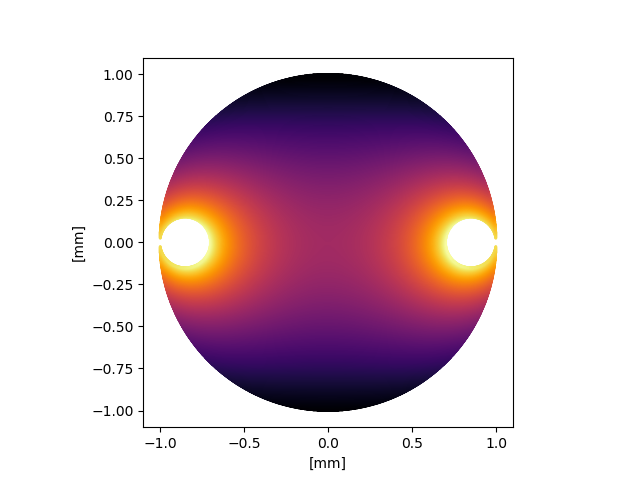

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_aspect('equal', 'box')
plt.xlabel('[mm]')
plt.ylabel('[mm]')
p = ax.scatter(1e3*x, 1e3*y, c = np.log(E_t), s = 1, cmap='inferno')
plt.savefig('Efield_tube.png',format='png')

In [41]:
#generate points for calculateion (more)
x,y = generateGrid(N,halfDistance,wire,tube)
E_x, E_y = getE(x,y,halfDistance,maxVoltage)
E_t = np.sqrt(E_x**2+E_y**2)

I am creating a pseudo-histogram of a density function of the E-field values. The x-axis are the E_x values, the y axis is a number of repetitions of values around that one. 

In [42]:
Exhist, Exbin_edges = np.histogram(E_x,bins=m)
E_xAv = np.average(E_x)
np.savetxt("ExDist.csv",(Exhist,Exbin_edges[:-1]),delimiter=',')

An average E-field in the sample is 52314.4202656 V/m.
Compare with a value for a flat capacitor of the same distance between: 88235.29411764706 V/m.
The graph has a long tail due to the points very close to the wires.


<IPython.core.display.Javascript object>


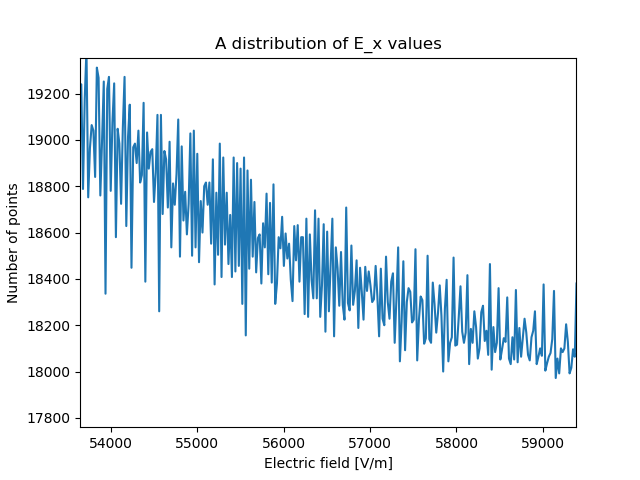

In [43]:
print("An average E-field in the sample is "+str(E_xAv)+" V/m.")
E_flat = maxVoltage/(2*halfDistance)
print("Compare with a value for a flat capacitor of the same distance between: "+str(E_flat)+ " V/m.")
print("The graph has a long tail due to the points very close to the wires.")

plt.figure()
plt.plot(Exbin_edges[:-1],Exhist)
plt.title("A distribution of E_x values")
plt.xlabel("Electric field [V/m]")
plt.ylabel("Number of points")
plt.savefig('Exdist.png',format='png')

In [44]:
Ethist, Etbin_edges = np.histogram(E_t,bins=m)
E_tAv = np.average(E_t)

np.savetxt("EtDist.csv",(Ethist,Etbin_edges[:-1]),delimiter=',')

An average total E-field in the sample is 68018.2988906 V/m.
Compare with a value for a flat capacitor of the same distance between: 88235.29411764706 V/m.
The graph has a long tail due to the points very close to the wires.


<IPython.core.display.Javascript object>


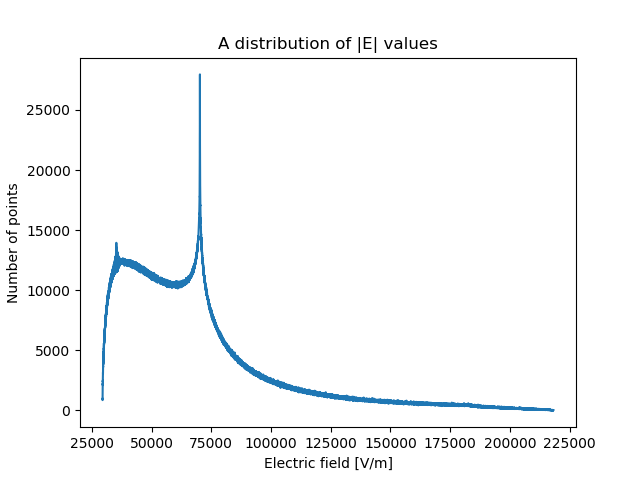

In [45]:
print("An average total E-field in the sample is "+str(E_tAv)+" V/m.")
E_flat = maxVoltage/(2*halfDistance)
print("Compare with a value for a flat capacitor of the same distance between: "+str(E_flat)+ " V/m.")
print("The graph has a long tail due to the points very close to the wires.")

plt.figure()
plt.plot(Etbin_edges[:-1],Ethist)
plt.title("A distribution of |E| values")
plt.xlabel("Electric field [V/m]")
plt.ylabel("Number of points")
plt.savefig('Edist.png',format='png')

In [46]:
factors = echoESweep(E_t,EScoupling,k,tottime)

|####################|100% done 



<IPython.core.display.Javascript object>


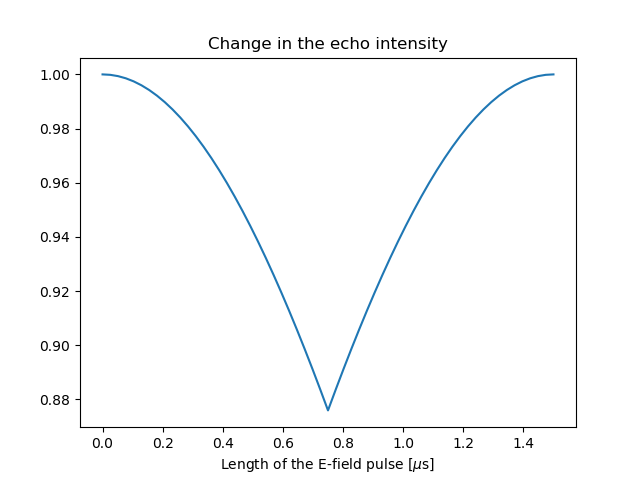

In [47]:
times = np.linspace(0,1e6*tottime,k)
plt.figure()
plt.plot(times, factors)
plt.title("Change in the echo intensity")
plt.xlabel(r"Length of the E-field pulse [$\mu$s]")
plt.savefig('e-field_sweep.png',format='png')